##W207 Final Project - Kaggle Competition

###Random Acts of Pizza

This dataset includes 5671 requests collected from the Reddit community Random Acts of Pizza between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request -- whether its author received a pizza or not -- is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.

Each JSON entry corresponds to one request (the first and only request by the requester on Random Acts of Pizza). We have removed fields from the test set which would not be available at the time of posting.

**Data fields**

"giver_username_if_known": Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise).

"number_of_downvotes_of_request_at_retrieval": Number of downvotes at the time the request was collected.

"number_of_upvotes_of_request_at_retrieval": Number of upvotes at the time the request was collected.

"post_was_edited": Boolean indicating whether this post was edited (from Reddit).

"request_id": Identifier of the post on Reddit, e.g. "t3_w5491".

"request_number_of_comments_at_retrieval": Number of comments for the request at time of retrieval.

"request_text": Full text of the request.

"request_text_edit_aware": Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous".

"request_title": Title of the request.

"requester_account_age_in_days_at_request": Account age of requester in days at time of request.

"requester_account_age_in_days_at_retrieval": Account age of requester in days at time of retrieval.

"requester_days_since_first_post_on_raop_at_request": Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP).

"requester_days_since_first_post_on_raop_at_retrieval": Number of days between requesters first post on RAOP and time of retrieval.

"requester_number_of_comments_at_request": Total number of comments on Reddit by requester at time of request.

"requester_number_of_comments_at_retrieval": Total number of comments on Reddit by requester at time of retrieval.

"requester_number_of_comments_in_raop_at_request": Total number of comments in RAOP by requester at time of request.

"requester_number_of_comments_in_raop_at_retrieval": Total number of comments in RAOP by requester at time of retrieval.

"requester_number_of_posts_at_request": Total number of posts on Reddit by requester at time of request.

"requester_number_of_posts_at_retrieval": Total number of posts on Reddit by requester at time of retrieval.

"requester_number_of_posts_on_raop_at_request": Total number of posts in RAOP by requester at time of request.

"requester_number_of_posts_on_raop_at_retrieval": Total number of posts in RAOP by requester at time of retrieval.

"requester_number_of_subreddits_at_request": The number of subreddits in which the author had already posted in at the time of request.

"requester_received_pizza": Boolean indicating the success of the request, i.e., whether the requester received pizza.

"requester_subreddits_at_request": The list of subreddits in which the author had already posted in at the time of request.

"requester_upvotes_minus_downvotes_at_request": Difference of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_minus_downvotes_at_retrieval": Difference of total upvotes and total downvotes of requester at time of retrieval.

"requester_upvotes_plus_downvotes_at_request": Sum of total upvotes and total downvotes of requester at time of request.

"requester_upvotes_plus_downvotes_at_retrieval": Sum of total upvotes and total downvotes of requester at time of retrieval.

"requester_user_flair": Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83).

"requester_username": Reddit username of requester.

"unix_timestamp_of_request": Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA).

"unix_timestamp_of_request_utc": Unit timestamp of request in UTC.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
from sklearn import metrics
from textblob import TextBlob

In [2]:
traindf = pd.read_json("train.json")
testdf = pd.read_json("test.json")

In [3]:
traindf.dtypes

giver_username_if_known                                  object
number_of_downvotes_of_request_at_retrieval               int64
number_of_upvotes_of_request_at_retrieval                 int64
post_was_edited                                           int64
request_id                                               object
request_number_of_comments_at_retrieval                   int64
request_text                                             object
request_text_edit_aware                                  object
request_title                                            object
requester_account_age_in_days_at_request                float64
requester_account_age_in_days_at_retrieval              float64
requester_days_since_first_post_on_raop_at_request      float64
requester_days_since_first_post_on_raop_at_retrieval    float64
requester_number_of_comments_at_request                   int64
requester_number_of_comments_at_retrieval                 int64
requester_number_of_comments_in_raop_at_

In [4]:
testdf.dtypes

giver_username_if_known                                object
request_id                                             object
request_text_edit_aware                                object
request_title                                          object
requester_account_age_in_days_at_request              float64
requester_days_since_first_post_on_raop_at_request    float64
requester_number_of_comments_at_request                 int64
requester_number_of_comments_in_raop_at_request         int64
requester_number_of_posts_at_request                    int64
requester_number_of_posts_on_raop_at_request            int64
requester_number_of_subreddits_at_request               int64
requester_subreddits_at_request                        object
requester_upvotes_minus_downvotes_at_request            int64
requester_upvotes_plus_downvotes_at_request             int64
requester_username                                     object
unix_timestamp_of_request                               int64
unix_tim

Hmm... the test data has a lot less features than train data does. Let's start by only exploring the data in both, plus whether the requester received pizza. Also, let's split the data into numerical features and text based features.

In [5]:
train_data = traindf.as_matrix(columns=['giver_username_if_known',
                  'request_id',
                  'request_text_edit_aware',
                  'request_title',
                  'requester_account_age_in_days_at_request',
                  'requester_days_since_first_post_on_raop_at_request',
                  'requester_number_of_comments_at_request',
                  'requester_number_of_comments_in_raop_at_request',
                  'requester_number_of_posts_at_request',
                  'requester_number_of_posts_on_raop_at_request',
                  'requester_number_of_subreddits_at_request',
                  'requester_upvotes_minus_downvotes_at_request',
                  'requester_upvotes_plus_downvotes_at_request',
                  'requester_username',
                  'unix_timestamp_of_request_utc'])

train_labels = traindf.as_matrix(columns=['requester_received_pizza'])

dev_data = train_data[3000:,:]
dev_labels = train_labels[3000:,:]

train_data = train_data[:3000,:]
train_labels = train_labels[:3000,:]

test_data = testdf.as_matrix()

# just numerical data
train_data_numerical = traindf.as_matrix(columns=['requester_account_age_in_days_at_request',
                                                  'requester_days_since_first_post_on_raop_at_request',
                                                  'requester_number_of_comments_at_request',
                                                  'requester_number_of_comments_in_raop_at_request',
                                                  'requester_number_of_posts_at_request',
                                                  'requester_number_of_posts_on_raop_at_request',
                                                  'requester_number_of_subreddits_at_request',
                                                  'requester_upvotes_minus_downvotes_at_request',
                                                  'requester_upvotes_plus_downvotes_at_request',
                                                  'unix_timestamp_of_request_utc'])

dev_data_numerical = train_data_numerical[3000:,:]
train_data_numerical = train_data_numerical[:3000,:]

Prediction time:

Start with using Random Forest on numerical features.

In [6]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(train_data_numerical, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(dev_data_numerical, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.6990384615384615)
('Accuracy of Random Forest with', 10, 'trees:', 0.73076923076923073)
('Accuracy of Random Forest with', 15, 'trees:', 0.72115384615384615)
('Accuracy of Random Forest with', 25, 'trees:', 0.71826923076923077)
('Accuracy of Random Forest with', 50, 'trees:', 0.73269230769230764)
('Accuracy of Random Forest with', 100, 'trees:', 0.73173076923076918)
('Accuracy of Random Forest with', 150, 'trees:', 0.73269230769230764)
('Accuracy of Random Forest with', 200, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 250, 'trees:', 0.73173076923076918)
('Accuracy of Random Forest with', 500, 'trees:', 0.7384615384615385)


73.75% accuracy with 100 trees, not bad. Let's dig into the request title.

In [7]:
req_reason = traindf.as_matrix(columns=['request_title'])

In [8]:
req = req_reason.tolist()

In [9]:
subjectivities = []
polarities = []
for r in range(len(req)):
    tmp = TextBlob(req[r][0])
    subjectivities.append(tmp.sentiment.subjectivity)
    polarities.append(tmp.sentiment.polarity)

In [10]:
new_train_data_numerical = traindf.as_matrix(columns=['requester_account_age_in_days_at_request',
                                                  'requester_days_since_first_post_on_raop_at_request',
                                                  'requester_number_of_comments_at_request',
                                                  'requester_number_of_comments_in_raop_at_request',
                                                  'requester_number_of_posts_at_request',
                                                  'requester_number_of_posts_on_raop_at_request',
                                                  'requester_number_of_subreddits_at_request',
                                                  'requester_upvotes_minus_downvotes_at_request',
                                                  'requester_upvotes_plus_downvotes_at_request',
                                                  'unix_timestamp_of_request_utc'])

In [11]:
s = np.array(subjectivities)
p = np.array(polarities)

In [12]:
sp = np.column_stack((s,p))

In [13]:
new_train_data_num = np.c_[new_train_data_numerical, sp]

In [14]:
sp_dev_data = sp[3000:,:]
sp_train_data = sp[:3000,:]

new_dev_data_numerical = new_train_data_num[3000:,:]
new_train_data_num = new_train_data_num[:3000,:]

Now let's try Random Forest again on:  
1) Just the request title sentiments  
2) The new numerical array, which joins the previous array with the sentiments

In [15]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(sp_train_data, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(sp_dev_data, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.72596153846153844)
('Accuracy of Random Forest with', 10, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 15, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 25, 'trees:', 0.73750000000000004)
('Accuracy of Random Forest with', 50, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 100, 'trees:', 0.73557692307692313)
('Accuracy of Random Forest with', 150, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 200, 'trees:', 0.73557692307692313)
('Accuracy of Random Forest with', 250, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 500, 'trees:', 0.73461538461538467)


Accuracy on predicting just on sentiment data topped out at 73.557% with 100 trees, which is not an improvement by itself. Let's see if adding the sentiment data to the previous numerical data helped.

In [16]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(new_train_data_num, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(new_dev_data_numerical, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.71442307692307694)
('Accuracy of Random Forest with', 10, 'trees:', 0.7221153846153846)
('Accuracy of Random Forest with', 15, 'trees:', 0.72980769230769227)
('Accuracy of Random Forest with', 25, 'trees:', 0.73653846153846159)
('Accuracy of Random Forest with', 50, 'trees:', 0.74423076923076925)
('Accuracy of Random Forest with', 100, 'trees:', 0.74519230769230771)
('Accuracy of Random Forest with', 150, 'trees:', 0.74423076923076925)
('Accuracy of Random Forest with', 200, 'trees:', 0.74134615384615388)
('Accuracy of Random Forest with', 250, 'trees:', 0.74326923076923079)
('Accuracy of Random Forest with', 500, 'trees:', 0.74134615384615388)


Hmm... adding sentiment on the request title only boosted accuracy to 74.038%, an increase of only ~1/4 of a percent.  

Let's see if adding sentiment for the request text helps.

In [17]:
req_texts = traindf.as_matrix(columns=['request_text_edit_aware'])
req_text = req_texts.tolist()

In [18]:
subjectivities = []
polarities = []
for r in range(len(req_text)):
    tmp = TextBlob(req[r][0])
    subjectivities.append(tmp.sentiment.subjectivity)
    polarities.append(tmp.sentiment.polarity)

In [19]:
s = np.array(subjectivities)
p = np.array(polarities)

In [20]:
sp = np.column_stack((s,p))

In [21]:
sp_dev_data = sp[3000:,:]
sp_train_data = sp[:3000,:]

In [22]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(sp_train_data, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(sp_dev_data, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.72596153846153844)
('Accuracy of Random Forest with', 10, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 15, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 25, 'trees:', 0.73750000000000004)
('Accuracy of Random Forest with', 50, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 100, 'trees:', 0.73557692307692313)
('Accuracy of Random Forest with', 150, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 200, 'trees:', 0.73557692307692313)
('Accuracy of Random Forest with', 250, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 500, 'trees:', 0.73461538461538467)


In [23]:
new_train_data_num = np.c_[new_train_data_num, sp_train_data]
new_dev_data_numerical = np.c_[new_dev_data_numerical, sp_dev_data]

In [24]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(new_train_data_num, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(new_dev_data_numerical, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.70961538461538465)
('Accuracy of Random Forest with', 10, 'trees:', 0.7384615384615385)
('Accuracy of Random Forest with', 15, 'trees:', 0.71923076923076923)
('Accuracy of Random Forest with', 25, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 50, 'trees:', 0.74326923076923079)
('Accuracy of Random Forest with', 100, 'trees:', 0.73557692307692313)
('Accuracy of Random Forest with', 150, 'trees:', 0.74038461538461542)
('Accuracy of Random Forest with', 200, 'trees:', 0.73942307692307696)
('Accuracy of Random Forest with', 250, 'trees:', 0.73557692307692313)
('Accuracy of Random Forest with', 500, 'trees:', 0.73653846153846159)


Uh oh. Adding the request text sentiment scores without any preprocessing actually hurt our predicitive accuracy.  

Let's explore some of the common vocabularly in request text and how it correlates to success.

In [25]:
common_words = {'pizza':0, 'please':0, 'hungry':0, 'kids':0, 'money':0}
for r in range(len(req_text)):
    tmp = TextBlob(req[r][0])
    for word in common_words.keys():
        common_words[word] += tmp.word_counts[word]
common_words

{'hungry': 478, 'kids': 54, 'money': 249, 'pizza': 1577, 'please': 136}

Cool, now that we have word counts, do any of these words align with success?

In [26]:
def has_word(array, word):
    word_list = []
    for item in range(len(array)):
        tmp = TextBlob(array[item][0].lower())
        if tmp.word_counts[word] > 0:
            word_list.append(1)
        else:
            word_list.append(0)
    return np.array(word_list)

has_pizza = has_word(req_text, 'pizza')
has_please = has_word(req_text, 'please')
has_hungry = has_word(req_text, 'hungry')
has_kids = has_word(req_text, 'kids')
has_money = has_word(req_text, 'money')

In [27]:
print('has pizza matches train_labels', np.sum(has_pizza[0:3000]==np.ravel(train_labels)) / float(train_labels.shape[0]), '% of the time.')
print('has please matches train_labels', np.sum(has_please[0:3000]==np.ravel(train_labels)) / float(train_labels.shape[0]), '% of the time.')
print('has hungry matches train_labels', np.sum(has_hungry[0:3000]==np.ravel(train_labels)) / float(train_labels.shape[0]), '% of the time.')
print('has kids matches train_labels', np.sum(has_kids[0:3000]==np.ravel(train_labels)) / float(train_labels.shape[0]), '% of the time.')
print('has money matches train_labels', np.sum(has_money[0:3000]==np.ravel(train_labels)) / float(train_labels.shape[0]), '% of the time.')

('has pizza matches train_labels', 0.45466666666666666, '% of the time.')
('has please matches train_labels', 0.70599999999999996, '% of the time.')
('has hungry matches train_labels', 0.69633333333333336, '% of the time.')
('has kids matches train_labels', 0.74133333333333329, '% of the time.')
('has money matches train_labels', 0.64566666666666672, '% of the time.')


Cool! We see that pizza, the most commonly used word is not very predictive of success, but the key words may be useful. Let's plug in the non-pizza words into our numerical data matrix and run Random Forest model again.

In [28]:
key_words = np.column_stack((has_please, has_hungry, has_kids, has_money))

In [29]:
keywords_dev_data = key_words[3000:,:]
keywords_train_data = key_words[:3000,:]

In [30]:
new_train_data_num = np.c_[new_train_data_num, keywords_train_data]
new_dev_data_numerical = np.c_[new_dev_data_numerical, keywords_dev_data]

In [31]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(keywords_train_data, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(keywords_dev_data, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 10, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 15, 'trees:', 0.75384615384615383)
('Accuracy of Random Forest with', 25, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 50, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 100, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 150, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 200, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 250, 'trees:', 0.75480769230769229)
('Accuracy of Random Forest with', 500, 'trees:', 0.75480769230769229)


Alright! Accuracy boosted to 75.48% using just the key words! Let's try folding those into the existing numerical data.

In [32]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(new_train_data_num, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(new_dev_data_numerical, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.70192307692307687)
('Accuracy of Random Forest with', 10, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 15, 'trees:', 0.72692307692307689)
('Accuracy of Random Forest with', 25, 'trees:', 0.73461538461538467)
('Accuracy of Random Forest with', 50, 'trees:', 0.73653846153846159)
('Accuracy of Random Forest with', 100, 'trees:', 0.74519230769230771)
('Accuracy of Random Forest with', 150, 'trees:', 0.73942307692307696)
('Accuracy of Random Forest with', 200, 'trees:', 0.74326923076923079)
('Accuracy of Random Forest with', 250, 'trees:', 0.74230769230769234)
('Accuracy of Random Forest with', 500, 'trees:', 0.7384615384615385)


Well, that didn't hepl... maybe we should go back and take out the request_text sentiment scores.

In [33]:
new_train_data_num2 = np.copy(new_train_data_num)

In [34]:
new_train_data_num2.shape

(3000, 18)

In [35]:
train_data_numerical.shape

(3000, 10)

In [36]:
# Since the orignial numerical data had 10 features, the next two we added were request_title
# then we added request_text, we want to delete the 13th and 14th columns or the new numerical array
new_train_data_num2 = np.delete(new_train_data_num2,[12,13], axis=1)

In [37]:
new_train_data_num2.shape

(3000, 16)

In [38]:
new_dev_data_numerical2 = np.copy(new_dev_data_numerical)
new_dev_data_numerical2 = np.delete(new_dev_data_numerical2,[12,13], axis=1)

In [39]:
forests = [5, 10, 15, 25, 50, 100, 150, 200, 250, 500]
for trees in forests:    
    rf = RandomForestClassifier(random_state=42, n_estimators=trees)
    rf.fit(new_train_data_num2, np.ravel(train_labels))
    print('Accuracy of Random Forest with', trees,'trees:',rf.score(new_dev_data_numerical2, np.ravel(dev_labels)))

('Accuracy of Random Forest with', 5, 'trees:', 0.67884615384615388)
('Accuracy of Random Forest with', 10, 'trees:', 0.7336538461538461)
('Accuracy of Random Forest with', 15, 'trees:', 0.72788461538461535)
('Accuracy of Random Forest with', 25, 'trees:', 0.74134615384615388)
('Accuracy of Random Forest with', 50, 'trees:', 0.73942307692307696)
('Accuracy of Random Forest with', 100, 'trees:', 0.73942307692307696)
('Accuracy of Random Forest with', 150, 'trees:', 0.73750000000000004)
('Accuracy of Random Forest with', 200, 'trees:', 0.74038461538461542)
('Accuracy of Random Forest with', 250, 'trees:', 0.73653846153846159)
('Accuracy of Random Forest with', 500, 'trees:', 0.74134615384615388)


So far it doesn't seem like there is much difference between the numerical data available, the sentiment of the request or whether the request contains key words in determining if the request ends in success. Each method so far has ended in only 73-75% accuracy for predictions.

In [40]:
import toyplot

In [41]:
train_data_num_titles = ['req_age',
                         'days_1st_post',
                         'comments_req',
                         'comments_raop_req',
                         'req_posts',
                         'req_raop_posts',
                         'req_subreddits',
                         'req_net_upvotes',
                         'req_total_votes',
                         'unix_time',
                         'got_pizza']

Visualize correlations between the numerical categories and whether pizza was granted.

In [42]:
req_age = train_data_numerical[:,0]
days_1st_post = train_data_numerical[:,1]
comments_req = train_data_numerical[:,2]
comments_raop_req = train_data_numerical[:,3]
req_posts = train_data_numerical[:,4]
req_raop_posts = train_data_numerical[:,5]
req_subreddits = train_data_numerical[:,6]
req_net_upvotes = train_data_numerical[:,7]
req_total_votes = train_data_numerical[:,8]
unix_time  = train_data_numerical[:,9]
got_pizza = 1.0 * train_labels

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's start with looking at the distribution of numerical data available.

(array([ 2261.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   739.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

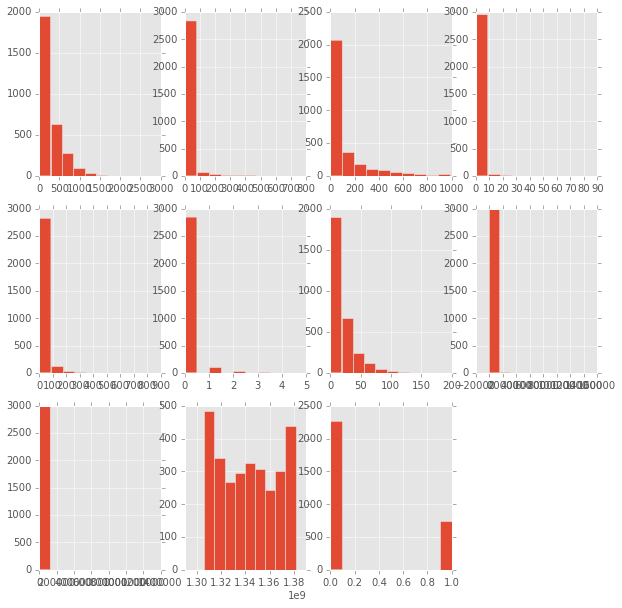

In [44]:
plt.figure(figsize=(10,10))
for i in range(1,11):
    plt.subplot(3,4,i)
    plt.hist(train_data_numerical[:,i-1])
plt.subplot(3,4,11)
plt.hist(got_pizza)

pretty much everything is biased towards zero. Maybe a transformation of the data would help...

In [51]:
train_data_numerical_w_pizza = np.c_[train_data_numerical, got_pizza]

In [65]:
success = np.where(train_data_numerical_w_pizza[:,10]>0)
failure = np.where(train_data_numerical_w_pizza[:,10]==0)

In [66]:
successes = train_data_numerical_w_pizza[success]
failures = train_data_numerical_w_pizza[failure]

Let's compare the distibutions overall vs the distributions for just success and just failure.

('req_age', '\n')
('days_1st_post', '\n')
('comments_req', '\n')
('comments_raop_req', '\n')
('req_posts', '\n')
('req_raop_posts', '\n')
('req_subreddits', '\n')
('req_net_upvotes', '\n')
('req_total_votes', '\n')
('unix_time', '\n')
('got_pizza', '\n')


ValueError: num must be 0 <= num <= 30, not 31

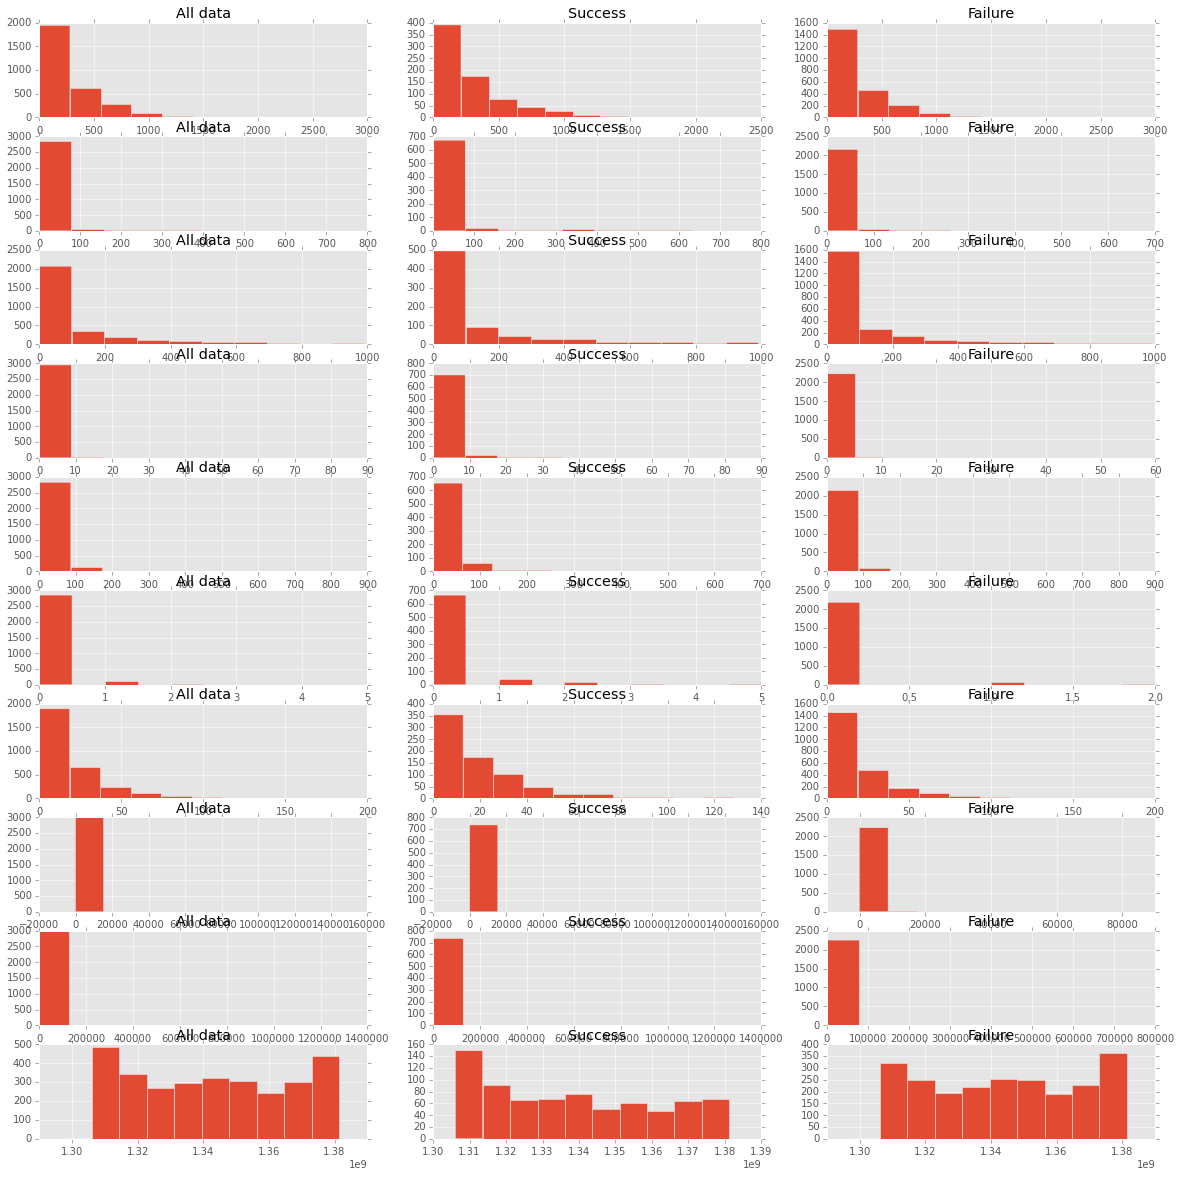

In [72]:
plt.figure(figsize=(20,20))
counter = 1
for i in range(11):
    print(train_data_num_titles[i], '\n')
    plt.subplot(10,3,counter)
    plt.title('All data')
    plt.hist(train_data_numerical[:,i])
    counter += 1
    plt.subplot(10,3,counter)
    plt.title('Success')
    plt.hist(successes[:,i])
    counter += 1
    plt.subplot(10,3,counter)
    plt.title('Failure')
    plt.hist(failures[:,i])
    counter += 1

Among the numerical data, only time of request and the number of subreddits the requester had at time of request seem to be aligned. 

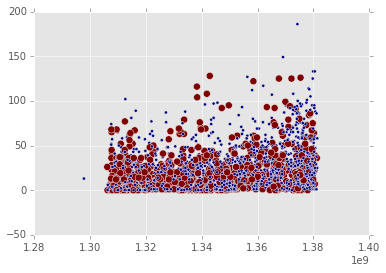

In [73]:
plt.scatter(unix_time, req_subreddits, s=10+(40*got_pizza), c=got_pizza)
#added weigths to got pizza so that successes are big red dots and failures are little blue dots